In [37]:
# Install packages (Prophet renamed to prophet)
!pip install numpy pandas scikit-learn xgboost prophet streamlit pyngrok joblib matplotlib seaborn --quiet
!pip install -U scikit-learn --quiet
!pip install streamlit prophet pyngrok




In [38]:
from google.colab import files
uploaded = files.upload()  # upload your sales.csv



Saving sales.csv to sales (1).csv


In [39]:
import pandas as pd
df = pd.read_csv('sales.csv')
df.head()


,date,sales
0,2018-01-01,207.45
1,2018-02-01,214.13
2,2018-03-01,238.11
3,2018-04-01,256.46
4,2018-05-01,227.29


Data Cleaning & Preprocessing

In [40]:
#Preprocessing
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

#monthly frequency
df = df.set_index('date').resample('M').sum().reset_index()




/tmp/ipython-input-2407879206.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.set_index('date').resample('M').sum().reset_index()


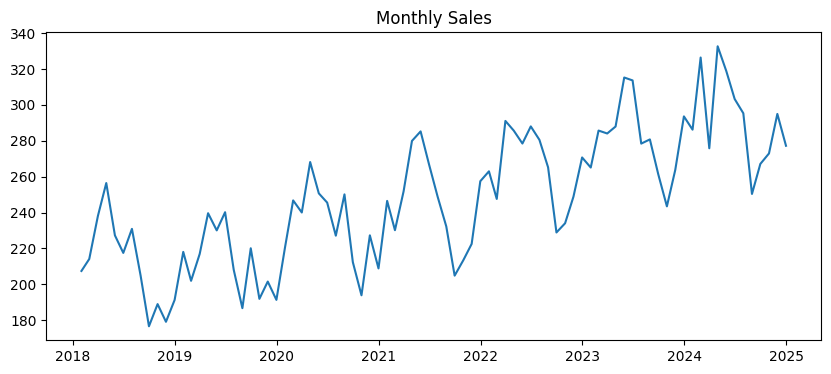

In [41]:
#Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['sales'])
plt.title("Monthly Sales")
plt.show()

Feature Engineering (for XGBoost)

In [42]:
def create_features(df):
    df = df.copy()
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['lag_1'] = df['sales'].shift(1)
    df['lag_12'] = df['sales'].shift(12)
    df['rolling_mean_3'] = df['sales'].shift(1).rolling(window=3).mean()
    df['rolling_mean_6'] = df['sales'].shift(1).rolling(window=6).mean()
    return df.dropna()

df_feat = create_features(df)
df_feat.head()


,date,sales,month,year,lag_1,lag_12,rolling_mean_3,rolling_mean_6
12,2019-01-31,218.09,1,2019,191.27,207.45,186.456667,195.310000
13,2019-02-28,201.96,2,2019,218.09,214.13,196.160000,193.171667
14,2019-03-31,216.97,3,2019,201.96,238.11,203.773333,192.673333
15,2019-04-30,239.64,4,2019,216.97,256.46,212.340000,199.398333
16,2019-05-31,230.07,5,2019,239.64,227.29,219.523333,207.841667


Train/Test Split (time-based)

In [43]:
train_size = int(len(df_feat)*0.8)
train, test = df_feat[:train_size], df_feat[train_size:]

X_train = train.drop(['sales','date'], axis=1)
y_train = train['sales']
X_test = test.drop(['sales','date'], axis=1)
y_test = test['sales']


**Model 1 — XGBoost**

In [44]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)
xgb_model.fit(X_train, y_train)

pred_xgb = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, pred_xgb))
print(f"XGBoost MAE={mae:.2f}  RMSE={rmse:.2f}")


XGBoost MAE=15.51  RMSE=19.08


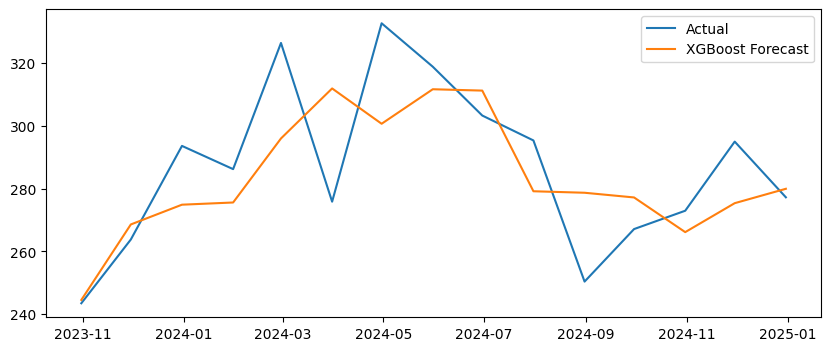

In [45]:
plt.figure(figsize=(10,4))
plt.plot(test['date'], y_test, label='Actual')
plt.plot(test['date'], pred_xgb, label='XGBoost Forecast')
plt.legend()
plt.show()


**Model 2 — Prophet**

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgo7xa2mp/ga0dxkj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgo7xa2mp/5790btio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99819', 'data', 'file=/tmp/tmpgo7xa2mp/ga0dxkj8.json', 'init=/tmp/tmpgo7xa2mp/5790btio.json', 'output', 'file=/tmp/tmpgo7xa2mp/prophet_modeljcjc8cdi/prophet_model-20251021073907.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:39:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:39:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE=14.30  RMSE=18.91


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


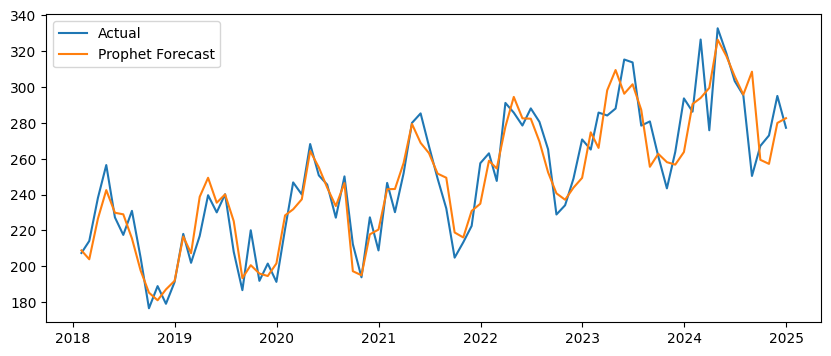

In [46]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df_prophet = df.rename(columns={'date':'ds','sales':'y'})
train_p = df_prophet.iloc[:train_size]
test_p = df_prophet.iloc[train_size:]

m = Prophet(yearly_seasonality=True)
m.fit(train_p)

future = m.make_future_dataframe(periods=len(test_p), freq='M')
forecast = m.predict(future)

# Evaluation
prophet_pred = forecast.iloc[-len(test_p):]['yhat']
mae_p = mean_absolute_error(test_p['y'], prophet_pred)
rmse_p = np.sqrt(mean_squared_error(test_p['y'], prophet_pred))

print(f"Prophet MAE={mae_p:.2f}  RMSE={rmse_p:.2f}")

# Visualization
plt.figure(figsize=(10,4))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast')
plt.legend()
plt.show()


Compare Models

In [47]:
comparison = pd.DataFrame({
    'Model': ['XGBoost', 'Prophet'],
    'MAE': [mae, mae_p],
    'RMSE': [rmse, rmse_p]
})
comparison


,Model,MAE,RMSE
0,XGBoost,15.507951,19.079443
1,Prophet,14.300602,18.906694


Forecast Next Month

In [48]:
# Using XGBoost model (as example)
last_row = df_feat.iloc[-1:].copy()
# Create feature row for next month
import datetime
next_date = last_row['date'].iloc[0] + pd.DateOffset(months=1)
new = pd.DataFrame({
    'date':[next_date],
    'month':[next_date.month],
    'year':[next_date.year],
    'lag_1':[last_row['sales'].values[0]],
    'lag_12':[df_feat.iloc[-12]['sales'] if len(df_feat)>=12 else last_row['sales'].values[0]],
    'rolling_mean_3':[df_feat['sales'].tail(3).mean()],
    'rolling_mean_6':[df_feat['sales'].tail(6).mean()]
})
forecast_next = xgb_model.predict(new.drop('date',axis=1))[0]
print(f"📅 Forecast for {next_date.strftime('%b %Y')}: {forecast_next:.2f}")


📅 Forecast for Jan 2025: 276.89
